In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from scipy.spatial import distance
from scipy import ndimage as nd

In [67]:
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(15,15)):
    
    _, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

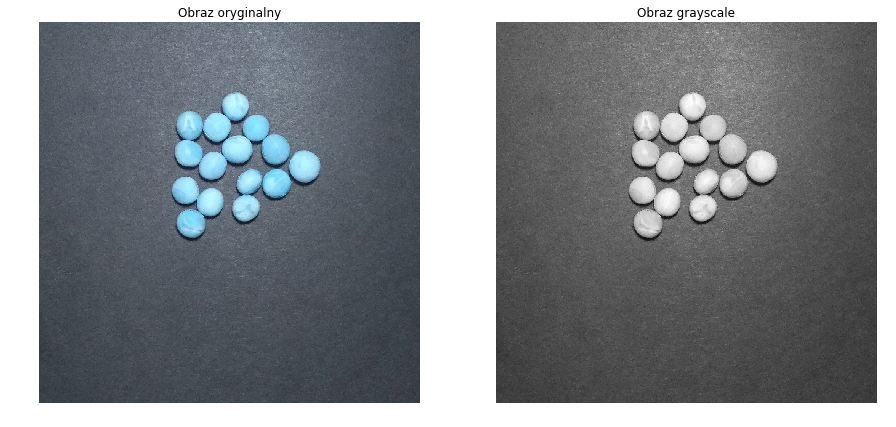

In [68]:
#wczytanie obrazu i przekonwertowanie go z RGB do GRAYSCALE
img = cv2.imread('15.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
show2imgs(img, img_gray,"Obraz oryginalny","Obraz grayscale")

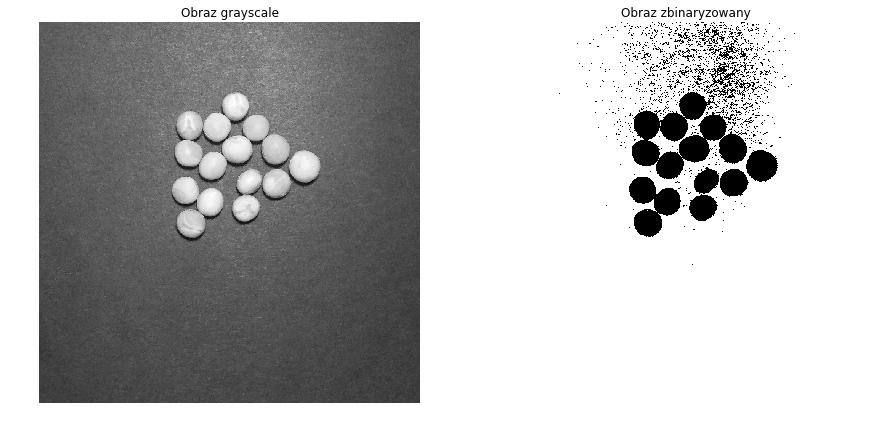

In [69]:
#Zbinaryzowanie obrazu przy odpowiednio dobranym progu
prog = 130
prog, img_bin = cv2.threshold(img_gray, thresh=prog, maxval=255, type=cv2.THRESH_BINARY_INV)
show2imgs(img_gray, img_bin,"Obraz grayscale","Obraz zbinaryzowany")

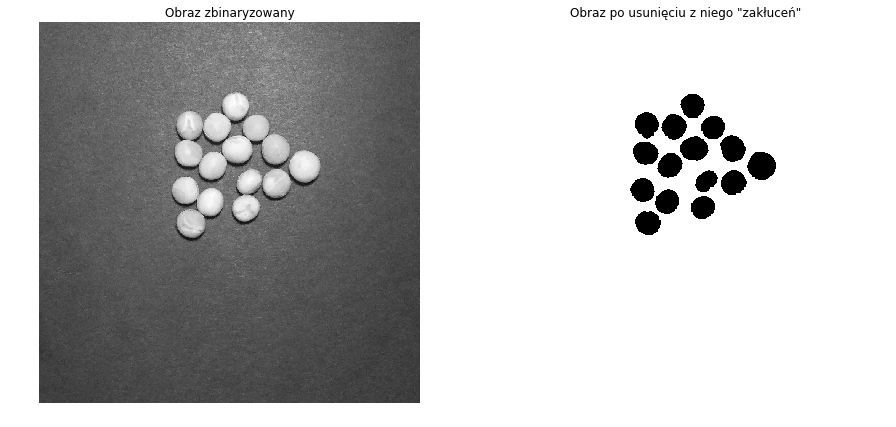

In [70]:
#wykonanie operacji zamknięcia w celu wyeliminowania "zakłóceń" oraz dylatacji w celu rozdzielenia obiektów
kernel = np.ones((3,3),np.uint8)
img_closed = cv2.morphologyEx(img_bin,cv2.MORPH_CLOSE,kernel, iterations = 3)
img_dilated = cv2.dilate(img_bin, kernel=kernel, iterations= 3)

show2imgs(img_gray, img_dilated,"Obraz zbinaryzowany",'Obraz po usunięciu z niego "zakłuceń"')

In [71]:
#Poniższa funkcja oblicza wartość procentową obiektów występujących na obrazie
def objperc(img, points = 0, whole = 0):
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            whole+=1
            if img[y,x] == 0:
                points += 1
    return (points/whole)*100

print("\tObiekty zajmuja ~%.2f%% powierzchni obrazu" % objperc(img_closed))

	Obiekty zajmuja ~6.13% powierzchni obrazu


In [72]:
#Sekwencja operacji umożliwiająca wyznaczenie liczby obiektów znajdujących się na obrazie.
binary = img_dilated < prog
label_objects, nb_labels = nd.label(binary)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects]

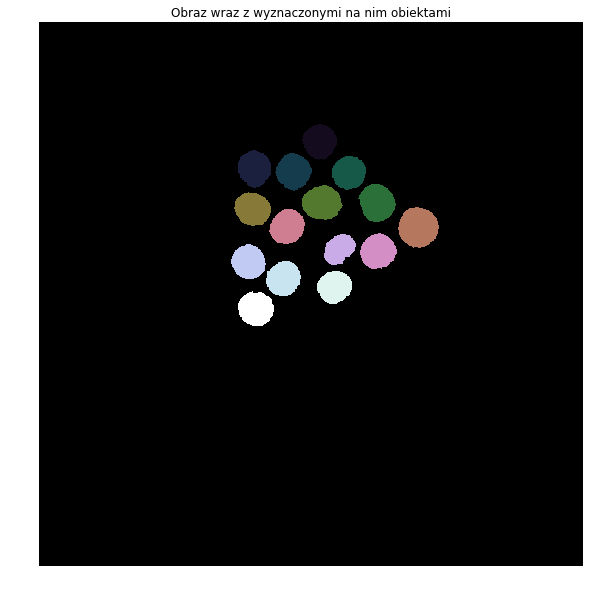

	Liczba obiektow na obrazie wynosi: 15


In [74]:
plt.figure(figsize=(10,10))
plt.imshow(label_objects,cmap='cubehelix')
plt.axis('off')
plt.title("Obraz wraz z wyznaczonymi na nim obiektami")
plt.show()
print("\tLiczba obiektow na obrazie wynosi:",nb_labels)

In [73]:
#Funkcja wyznaczająca środek ciężkości dla każdego obiektu znajdującego się na obrazie
def central(img, objNumber):
    cx = 0
    cy = 0
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

#funkcja wyznaczajaca srodek ciezkosci dla konkretnego obiektu
def central2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]


cogs = []
for i in range(nb_labels):
    cogs.append(central(label_objects, i+1))

for obj in cogs:
    print(obj)

(219, 515)
(269, 395)
(274, 467)
(276, 569)
(331, 621)
(332, 520)
(343, 392)
(377, 696)
(375, 455)
(421, 622)
(417, 551)
(440, 384)
(471, 449)
(486, 542)
(526, 398)


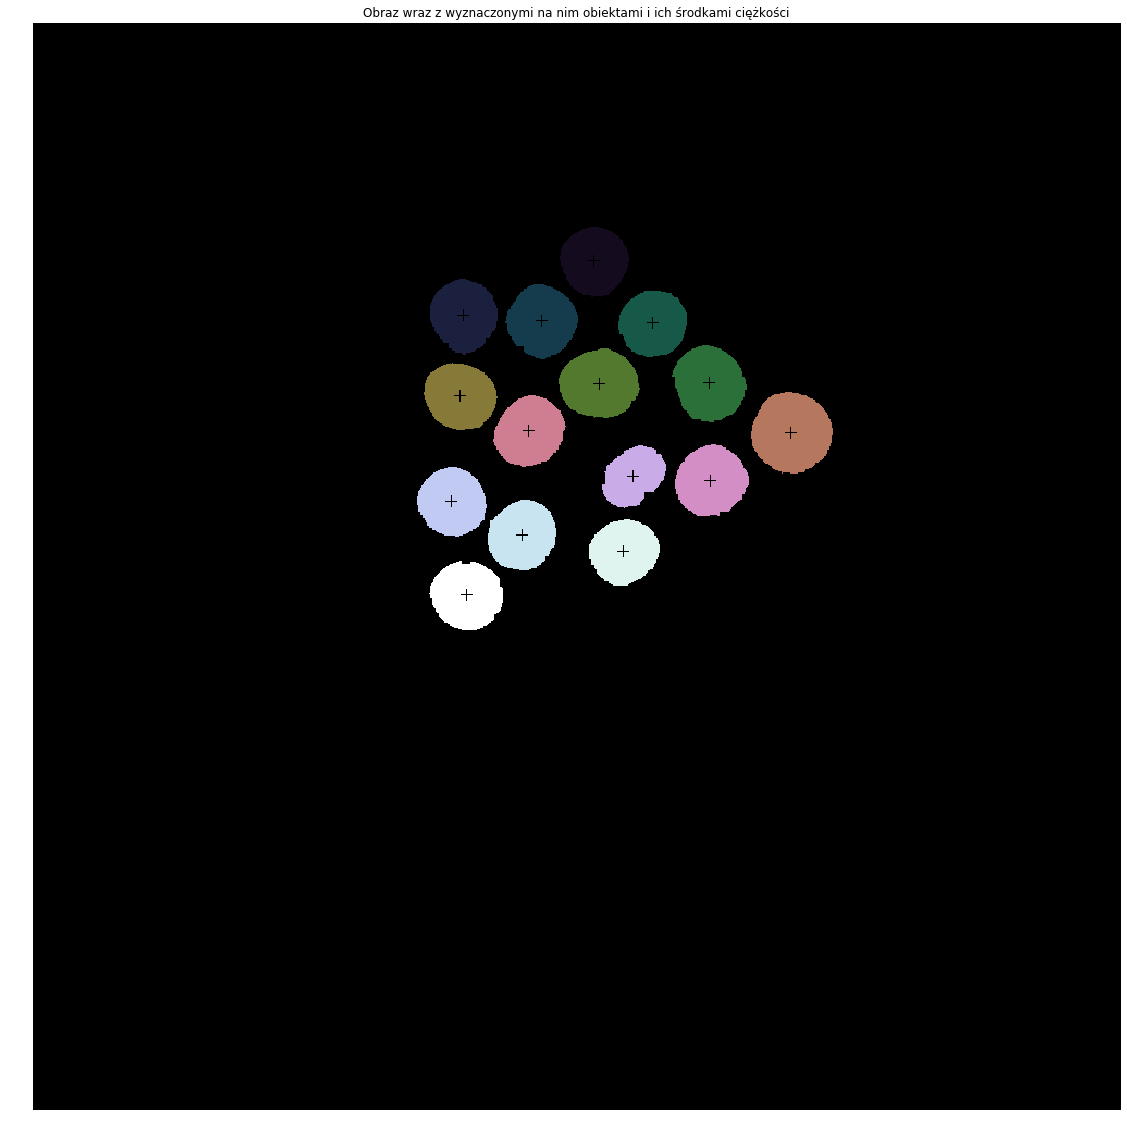

In [76]:
#Funkcja korzysta z wyznaczonych wcześniej środków ciężkośi i oznacza je na obiektach
def drawCross(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-5, y+6):
            image[j,x] = 0
        for i in range(x-5, x+6):
            image[y,i] = 0
            
    return image


lo = drawCross(label_objects, cogs)
plt.figure(figsize=(20,20))
plt.imshow(lo,cmap='cubehelix')
plt.axis('off')
plt.title("Obraz wraz z wyznaczonymi na nim obiektami i ich środkami ciężkości")
plt.show()

In [75]:
#funkcja do pobierania konkretnego obiektu
def getFigure(img, objNumber):
    
    dots = []
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y,x] == objNumber:
                dots.append((y,x))

    return dots

In [77]:
def Blair_Bliss(points):
    s = len(points)
    my,mx = central2(points)
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
    return s/(math.sqrt(2*math.pi*r))

In [78]:
def Feret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)

In [79]:
print('\n___________OBLICZONE_WSPÓŁCZYNNIKI_DLA_OBIEKTÓW___________\n')
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = Blair_Bliss(pts)
    feret = Feret(pts)
    
    print("Obiekt ",i+1,'\nŚrodek ciężkości: ',cogs[i], '\nBlair-Bliss: ', bb,'\nFeret: ',feret, '\n__________________________________________________________\n')


___________OBLICZONE_WSPÓŁCZYNNIKI_DLA_OBIEKTÓW___________

Obiekt  1 
Środek ciężkości:  (219, 515) 
Blair-Bliss:  0.9988105497326802 
Feret:  1.0158730158730158 
__________________________________________________________

Obiekt  2 
Środek ciężkości:  (269, 395) 
Blair-Bliss:  0.995940696654719 
Feret:  1.1311475409836065 
__________________________________________________________

Obiekt  3 
Środek ciężkości:  (274, 467) 
Blair-Bliss:  0.9979802278795871 
Feret:  1.0303030303030303 
__________________________________________________________

Obiekt  4 
Środek ciężkości:  (276, 569) 
Blair-Bliss:  0.9989453777901649 
Feret:  0.967741935483871 
__________________________________________________________

Obiekt  5 
Środek ciężkości:  (331, 621) 
Blair-Bliss:  0.995793057241826 
Feret:  1.0294117647058822 
__________________________________________________________

Obiekt  6 
Środek ciężkości:  (332, 520) 
Blair-Bliss:  0.9927804447943399 
Feret:  0.8513513513513513 
__________________